In [71]:
%load_ext autoreload
%autoreload 2

import osqp
import numpy as np
import cvxpy as cp

import matplotlib.pyplot as plt

from scipy import sparse

from free_flyer.free_flyer import FreeFlyer
from free_flyer.utils import *
from free_flyer.osqp import OsqpSolver

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
ft2m = 0.3048
posmax = ft2m*np.array([12.,9.])

in2m = 0.0254
widths = 0.27
inflate = 0.2

max_box_size = widths + inflate + 0.1
min_box_size = widths + inflate + 0.05
box_buffer = 0.025
border_size = 0.05

prob_success_micp, prob_success_cp, prob_success_osqp = False, False, False

In [128]:
prob = FreeFlyer()
prob.Q

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 2., 0.],
       [0., 0., 0., 2.]])

In [9]:
obstacles = random_obs(prob.n_obs, prob.posmin, prob.posmax, border_size, box_buffer, min_box_size, max_box_size)
x0 = findIC(obstacles, prob.posmin, prob.posmax, prob.velmin, prob.velmax)
xg  = np.hstack((0.9*prob.posmax, np.zeros(prob.n)))

p_dict = {}
p_dict['x0'] = x0
p_dict['xg'] = xg
p_dict['obstacles'] = np.reshape(np.concatenate(obstacles, axis=0), (prob.n_obs,4)).T

In [194]:
mpc_steps = 30

obstacles = random_obs(prob.n_obs, prob.posmin, prob.posmax, border_size, box_buffer, min_box_size, max_box_size)
x0 = findIC(obstacles, prob.posmin, prob.posmax, prob.velmin, prob.velmax)

x0 = np.array([3.45766099, 2.319038  , 0.07564046, 0.10704452])
x0 = np.array([1.0, 1.75, 0.0, 0.0])
obstacles = [np.array([1.02973002, 1.64086839, 2.02422747, 2.64371869]),
 np.array([0.9140886 , 1.50496808, 1.02429705, 1.63335429]),
 np.array([2.77171056, 3.38319568, 1.85434365, 2.46014876]),
 np.array([2.00013685, 2.58634515, 1.70685483, 2.3153834 ]),
 np.array([0.21254897, 0.80080141, 1.94684917, 2.55200543]),
 np.array([2.56873257, 3.14185899, 1.04887716, 1.64513089]),
 np.array([0.876186  , 1.45858714, 0.33663042, 0.95024701]),
 np.array([0.06269455, 0.64719652, 0.7221137 , 1.29620343])]

X_opts_micp = x0
X_opts_osqp = x0
osqp_prob = OsqpSolver(prob, verbose=False)

for ii_mpc in range(mpc_steps):
    p_dict = {}
    p_dict['x0'] = x0
    p_dict['xg'] = xg
    p_dict['obstacles'] = np.reshape(np.concatenate(obstacles, axis=0), (prob.n_obs,4)).T

    # Solve using Gurobi
    prob_success_micp, cost_micp, solve_time_micp, optvals_micp = prob.solve_micp(p_dict, solver=cp.MOSEK)

    if not prob_success_micp:
        print('Gurobi failed at {}'.format(ii_mpc))
        break

    u0 = optvals_micp[1][:,0]
    x0_new = prob.Ak @ x0 + prob.Bk @ u0
    X_opts_micp = np.vstack((X_opts_micp, x0_new))

    # Solve using OSQP controller
    y_opt = optvals_micp[-1]
    if ii_mpc == 0:
        osqp_prob.setup_prob(p_dict, y_opt)
    else:
        osqp_prob.update_prob(p_dict, y_opt)

    prob_success_osqp, optvals_osqp = osqp_prob.solve()
    if not prob_success_osqp:
        print('OSQP failed at {}'.format(ii_mpc))
        break

    u0 = optvals_osqp[1][:,0]
    x0_new = prob.Ak @ x0 + prob.Bk @ u0
    X_opts_osqp = np.vstack((X_opts_osqp, x0_new))

    # Propagate state forward
    x0 = x0_new
print('Terminated after {} steps'.format(ii_mpc))
    
X_opts_micp = X_opts_micp.T
X_opts_osqp = X_opts_osqp.T

Gurobi failed at 27
Terminated after 27 steps


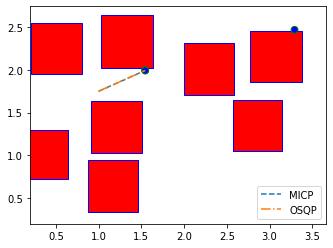

<Figure size 432x288 with 0 Axes>

In [190]:
plt.axes()
for obstacle in obstacles:
    rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                              obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                             fc='red', ec='blue')
    plt.gca().add_patch(rectangle)
    plt.axis('scaled')

if x0.size > 0:
    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="green")
plt.gca().add_patch(circle)    

ax = plt.gca()
ax.margins(0)
ax.set(xlim=(prob.posmin[0],prob.posmax[0]), ylim=(prob.posmin[1],prob.posmax[1]))

plt.plot(X_opts_micp[0,:], X_opts_micp[1,:], label='MICP', linestyle='--')
plt.plot(X_opts_osqp[0,:], X_opts_osqp[1,:],  label='OSQP', linestyle='-.')

circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="green")
plt.gca().add_patch(circle)

circle = plt.Circle((xg[0],xg[1]), 0.04, fc='blue',ec="green")
plt.gca().add_patch(circle)

plt.legend()

fig = plt.figure()
plt.show()